# Module 2 - Introduction to Forecasting with __Python__

## Lectures

### Introduction

In the first lecture, a simple linear model of the type


$log(F_{gdp}) = c + log(A_{gdp})$

is estimated, visualized, and briefly analyzed. Let's see how to do it in Python using `statsmodels`.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.formula.api as fsm
import statsmodels.api as sm

In [161]:
df = pd.read_csv("data/Module_2_Fiji_fiji.csv")
df.head()

,Date,RGDP_FIJI,G_REAL_GROWTH_FIJI,RGDP_AUS,G_REAL_GROWTH_AUS,REER_FIJI,SUGAROUTPUT_FIJI,G_SUGAR_OUTPUT,SUGAROUTPUT_FIJI_MISSING
0,1970.0,1.6316,NaN,406.2,NaN,NaN,NaN,NaN,NaN
1,1971.0,1.7436,6.864428,421.7,3.815854,NaN,NaN,NaN,NaN
2,1972.0,1.8744,7.501721,429.7,1.897083,NaN,NaN,NaN,NaN
3,1973.0,2.0921,11.614383,451.4,5.050035,NaN,NaN,NaN,NaN
4,1974.0,2.1453,2.542899,458.0,1.462118,NaN,NaN,NaN,NaN


Let's do some precleaning to keep only `date`, `rgdp_fiji`, and `rgdp_aus`.

In [162]:
df.columns = [x.lower() for x in df.columns]
df = df[["date", "rgdp_fiji", "rgdp_aus"]]
df.head()

,date,rgdp_fiji,rgdp_aus
0,1970.0,1.6316,406.2
1,1971.0,1.7436,421.7
2,1972.0,1.8744,429.7
3,1973.0,2.0921,451.4
4,1974.0,2.1453,458.0


In [164]:
# Transform into logs:
df1 = (df
    .assign(
        log_rgdp_fiji=np.log(df.rgdp_fiji),
        log_rgdp_aus=np.log(df.rgdp_aus)
    )
    .dropna()
)

In [165]:
X = df1.log_rgdp_aus
X = sm.add_constant(X)
Y = df1.log_rgdp_fiji
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_rgdp_fiji   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1867.
Date:                Thu, 14 Oct 2021   Prob (F-statistic):           1.92e-36
Time:                        14:48:32   Log-Likelihood:                 70.269
No. Observations:                  44   AIC:                            -136.5
Df Residuals:                      42   BIC:                            -133.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.1952      0.124    -33.878      0.000      -4.445      -3.945
log_rgdp_aus     0.8010      0.019     43.208      0.000       0.764       0.838
==============================================================================
Omnibus:                        4.947   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.232
Skew:                          -0.758   Prob(JB):                        0.121
Kurtosis:                       3.105   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To finish with the introduction, let's plot the dependent variable, the predicted values, and the residuals:

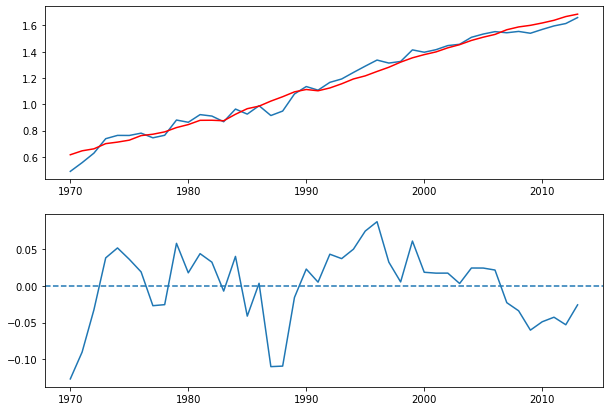

In [166]:
fig, ax = plt.subplots(2, figsize=(10, 7))

ax[0].plot(df1.date, Y)
ax[0].plot(df1.date, results.predict(), color="r");

ax[1].plot(df1.date, results.resid)
ax[1].axhline(0, ls='--');


## Session 3: Equation Object: Allowing for Additional Variables, Including Dynamics

In this session, we add additional variables and lags to the model presented in the introduction.

First, we add sugar production and a dummy variable to cover the 2008 crisis period:

$log(F_{gdp}) = c + log(A_{gdp}) + log(F_{sugar}) + GFC_{07-10}$

In [203]:
# Reload csv and make transformations
df = pd.read_csv("data/Module_2_Fiji_fiji.csv")
df.columns = [x.lower() for x in df.columns]
df = df.loc[:, ["date", "rgdp_fiji", "rgdp_aus", "sugaroutput_fiji"]]
df.head(15)


,date,rgdp_fiji,rgdp_aus,sugaroutput_fiji
0,1970.0,1.6316,406.2,NaN
1,1971.0,1.7436,421.7,NaN
2,1972.0,1.8744,429.7,NaN
3,1973.0,2.0921,451.4,NaN
4,1974.0,2.1453,458.0,NaN
5,1975.0,2.1442,466.6,NaN
6,1976.0,2.1821,487.2,NaN
7,1977.0,2.1063,493.6,NaN
8,1978.0,2.1472,504.7,NaN
9,1979.0,2.4111,525.8,NaN


In [204]:
df = (
    df
    .pipe(lambda x: x.assign(
        # Create a dummy for GFC
        gfc=np.where(x.date.isin([2007, 2008, 2009,2010]), 1, 0),
        # Create lags
        **{f'lag_{col.name}': col.shift(1) for col in [x.rgdp_fiji, x.rgdp_aus]}
    ))
    .pipe(lambda x: x.assign(
        # Create logs
        **{f'log_{col.name}': np.log(col) for col in [x.rgdp_fiji, x.rgdp_aus, x.sugaroutput_fiji, x.lag_rgdp_fiji, x.lag_rgdp_aus]}
        ))
    .dropna()
)
df.tail(10)

,date,rgdp_fiji,rgdp_aus,sugaroutput_fiji,gfc,lag_rgdp_fiji,lag_rgdp_aus,log_rgdp_fiji,log_rgdp_aus,log_sugaroutput_fiji,log_lag_rgdp_fiji,log_lag_rgdp_aus
34,2004.0,4.5238,1202.7,3001.0,0,4.2897,1155.4,1.509352,7.092324,8.006701,1.456217,7.052202
35,2005.0,4.6368,1240.4,2789.0,0,4.5238,1202.7,1.534024,7.123189,7.933438,1.509352,7.092324
36,2006.0,4.7229,1273.5,3226.0,0,4.6368,1240.4,1.552423,7.149524,8.078998,1.534024,7.123189
37,2007.0,4.6823,1331.4,2478.0,1,4.7229,1273.5,1.543789,7.193986,7.815207,1.552423,7.149524
38,2008.0,4.7306,1367.2,2321.0,1,4.6823,1331.4,1.554052,7.220520,7.749753,1.543789,7.193986
39,2009.0,4.6650,1388.3,2247.0,1,4.7306,1367.2,1.540088,7.235835,7.717351,1.554052,7.220520
40,2010.0,4.8029,1419.5,1778.0,1,4.6650,1388.3,1.569220,7.258060,7.483244,1.540088,7.235835
41,2011.0,4.9328,1456.3,2096.0,0,4.8029,1419.5,1.595907,7.283654,7.647786,1.569220,7.258060
42,2012.0,5.0231,1508.8,1640.0,0,4.9328,1456.3,1.614047,7.319070,7.402452,1.595907,7.283654
43,2013.0,5.2563,1543.9,1760.0,0,5.0231,1508.8,1.659427,7.342067,7.473069,1.614047,7.319070


In [205]:
# Regress
X = df[["log_rgdp_aus", "log_sugaroutput_fiji", "gfc"]]
X = sm.add_constant(X)
y = df["log_rgdp_fiji"]

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_rgdp_fiji   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     657.5
Date:                Thu, 14 Oct 2021   Prob (F-statistic):           3.82e-20
Time:                        15:00:26   Log-Likelihood:                 65.292
No. Observations:                  24   AIC:                            -122.6
Df Residuals:                      20   BIC:                            -117.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.9662      0.328    -15.149      0.000      -5.650      -4.282
log_rgdp_aus             0.7977      0.026     30.225      0.000       0.743       0.853
log_sugaroutput_fiji     0.1015      0.021      4.891      0.000       0.058       0.145
gfc                     -0.0272      0.011     -2.511      0.021      -0.050      -0.005
==============================================================================
Omnibus:                        1.051   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.886
Skew:                          -0.211   Prob(JB):                        0.642
Kurtosis:                       2.159   Cond. No.                         985.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

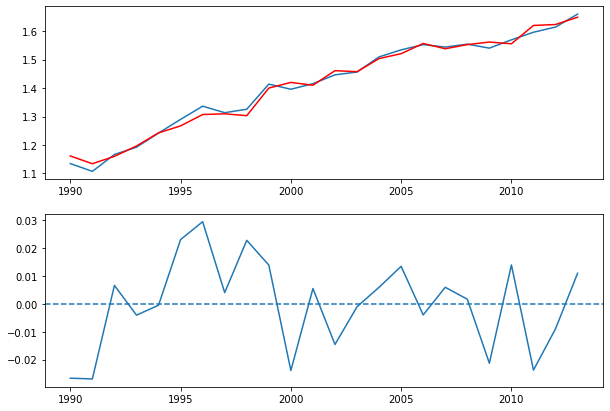

In [206]:
fig, ax = plt.subplots(2, figsize=(10, 7))

ax[0].plot(df.date, y)
ax[0].plot(df.date, results.predict(), color="r");

ax[1].plot(df.date, results.resid)
ax[1].axhline(0, ls='--');

In [207]:
X = df[["log_lag_rgdp_fiji", "log_rgdp_aus", "log_lag_rgdp_aus", "log_sugaroutput_fiji", "gfc"]]
X = sm.add_constant(X)
y = df["log_rgdp_fiji"]

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_rgdp_fiji   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     512.4
Date:                Thu, 14 Oct 2021   Prob (F-statistic):           9.57e-19
Time:                        15:00:29   Log-Likelihood:                 69.657
No. Observations:                  24   AIC:                            -127.3
Df Residuals:                      18   BIC:                            -120.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.3060      0.656     -6.562      0.000      -5.685      -2.927
log_lag_rgdp_fiji        0.1075      0.130      0.827      0.419      -0.166       0.381
log_rgdp_aus             1.3950      0.282      4.948      0.000       0.803       1.987
log_lag_rgdp_aus        -0.6950      0.263     -2.640      0.017      -1.248      -0.142
log_sugaroutput_fiji     0.0827      0.021      4.005      0.001       0.039       0.126
gfc                     -0.0231      0.010     -2.398      0.028      -0.043      -0.003
==============================================================================
Omnibus:                        2.449   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                1.256
Skew:                           0.168   Prob(JB):                        0.534
Kurtosis:                       1.931   Cond. No.                     2.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

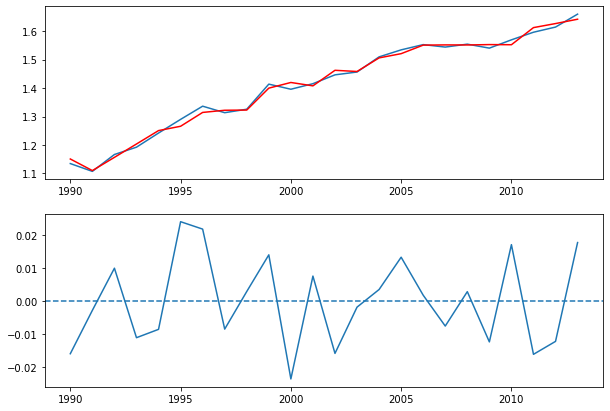

In [208]:
fig, ax = plt.subplots(2, figsize=(10, 7))

ax[0].plot(df.date, y)
ax[0].plot(df.date, results.predict(), color="r");

ax[1].plot(df.date, results.resid)
ax[1].axhline(0, ls='--');

In [215]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

acorr_breusch_godfrey(results, 3)

(5.915717405668231,
 0.11578353776420564,
 1.6355963734836065,
 0.22329029179806997)

## Questions

### Session 1

#### Question 2.5

We start by loading the data:

In [209]:
# We use skiprows=range(1, 2) to skip the first line in the CSV file (after the header) that contains info about the units
df_jam = pd.read_csv(
    "data/Module2_Caribbean_Assessment_File_Jamaica.csv", 
    skiprows=range(1,2), index_col=0, parse_dates=True)
df_bah = pd.read_csv(
    "data/Module2_Caribbean_Assessment_File_Bahamas.csv", 
    skiprows=range(1,2), index_col=0, parse_dates=True)

# Join two DataFrames
df = df_jam.join(df_bah).loc[:, ["jam_cpi_eop", "bah_cpi_eop"]]
df.head()

,jam_cpi_eop,bah_cpi_eop
1980-01-01,3.038,38.714
1981-01-01,3.183,42.193
1982-01-01,3.406,44.115
1983-01-01,3.974,45.653
1984-01-01,5.212,47.748


In [96]:
# Log-transform the variables and take the differences:
df = (df
 .assign(
     dljam_cpi=lambda x: np.log(x.jam_cpi_eop) - np.log(x.jam_cpi_eop.shift(1)),
     dlbah_cpi=lambda x: np.log(x.bah_cpi_eop) - np.log(x.bah_cpi_eop.shift(1)),
     )
 .dropna()
)
df.head()

,jam_cpi_eop,bah_cpi_eop,dljam_cpi,dlbah_cpi
1981-01-01,3.183,42.193,0.046625,0.086053
1982-01-01,3.406,44.115,0.067714,0.044546
1983-01-01,3.974,45.653,0.154235,0.034269
1984-01-01,5.212,47.748,0.271191,0.044868
1985-01-01,6.417,50.041,0.207987,0.046905


In [ ]:
# A more advanced usage of pandas (similar to dplyr's mutate ... across):
# df = (df
#  .pipe(lambda x: x.assign(**{f'l{col.name}': np.log(col) for col in [x.jam_cpi_eop, x.bah_cpi_eop]}))
#  .pipe(lambda x: x.assign(**{f'd{col.name}': col - col.shift(1) for col in [x.ljam_cpi_eop, x.lbah_cpi_eop]}))
# )

In [98]:
X = df["dljam_cpi"]
X = sm.add_constant(X)
y = df["dlbah_cpi"]
model = sm.OLS(y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dlbah_cpi   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     3.699
Date:                Thu, 14 Oct 2021   Prob (F-statistic):             0.0634
Time:                        12:42:48   Log-Likelihood:                 87.601
No. Observations:                  34   AIC:                            -171.2
Df Residuals:                      32   BIC:                            -168.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.005      3.972      0.000       0.011       0.033
dljam_cpi      0.0583      0.030      1.923      0.063      -0.003       0.120
==============================================================================
Omnibus:                       14.678   Durbin-Watson:                   0.614
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.630
Skew:                           1.368   Prob(JB):                     0.000404
Kurtosis:                       4.883   Cond. No.                         9.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Session 2

#### Question 2.6 

Which year did the inflation in Jamaica reach its highest value for the series?

Note that I'm taking advantage of the fact here that log-differences are approximately the same as percentage differences.

In [102]:
df.query('dljam_cpi == dljam_cpi.max()')

,jam_cpi_eop,bah_cpi_eop,dljam_cpi,dlbah_cpi
1991-01-01,22.906,69.456,0.588852,0.06213


To make sure that this is the correct answer, we can check the inflation rates in 2014 and 2006.

In [103]:
df.loc[["1991-01-01", "2014-01-01", "2006-01-01"], 'dljam_cpi']

1991-01-01    0.588852
2014-01-01    0.077885
2006-01-01    0.053476
Name: dljam_cpi, dtype: float64

#### Question 2.7

First, we need to load and clean the Atlantis data:

In [108]:
df = pd.read_csv("data/Module2_Caribbean_Assessment_File_Atlantis.csv", index_col=0, skiprows=range(1, 2), parse_dates=True)
df = df.loc[:, ["atl_infl", "atl_unemp_rate"]].dropna()
df.head()

,atl_infl,atl_unemp_rate
1991-01-01,5.551944,9.237
1992-01-01,4.311944,9.537
1993-01-01,3.738611,9.337
1994-01-01,9.065277,7.387
1995-01-01,6.511944,7.287


In [110]:
X = df.atl_unemp_rate
X = sm.add_constant(X)
y = df.atl_infl
model = sm.OLS(y, X)
results = model.fit()
results.params

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const             11.859023
atl_unemp_rate    -0.691685
dtype: float64